In [35]:
import torch
import numpy as np
import pandas as pd
import wfdb
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import random

In [10]:
# work done in hylian machine

waveform_summary = pd.read_csv("/scratch/mc-med/data/waveform_summary.csv")
waveform_summary = waveform_summary[waveform_summary['Type'] == 'II']
waveform_summary.head()

,CSN,Type,Segments,Duration
0,99633476,II,1,2204.742
4,99960476,II,4,12818.304
7,99470476,II,2,13918.498
11,99438476,II,2,11579.046
15,99439476,II,3,2853.788


In [11]:
Full_CSN = 99016000 # as an example 
waveform_summary[waveform_summary['CSN'] == Full_CSN]

,CSN,Type,Segments,Duration
58946,99016000,II,2,1166.926


In [12]:
## import computed alarms
alarms_df = pd.read_parquet('../data/sick_time.parquet', engine='pyarrow')
alarms_df.head()

,CSN,Alarm
0,98974916,2288-12-08 10:17:39
1,98975250,2279-10-24 08:40:37
2,98982225,2238-07-19 10:31:15
3,98990360,2242-01-14 19:43:37
4,98995384,2276-05-18 10:59:45


In [14]:
visits_df = pd.read_csv("/scratch/mc-med/data/visits.csv")
visits_df.head()

,MRN,CSN,Visit_no,Visits,Age,Gender,Race,Ethnicity,Means_of_arrival,Triage_Temp,...,Payor_class,Admit_service,Dx_ICD9,Dx_ICD10,Dx_name,Arrival_time,Roomed_time,Dispo_time,Admit_time,Departure_time
0,98880961,98874959,1,1,82,F,White,Non-Hispanic/Non-Latino,EMS,36.2,...,Medicare,Medicine,873.20,S01.21XA,"Laceration of nose, initial encounter",2283-03-02T07:36:59Z,2283-03-02T07:36:59Z,2283-03-02T12:29:59Z,2283-03-02T12:29:59Z,2283-03-02T13:44:59Z
1,99121566,99354408,1,2,59,F,Other,Non-Hispanic/Non-Latino,EMS,36.8,...,NaN,Emergency Medicine,780.97,R41.82,"Altered mental status, unspecified altered men...",2239-08-22T01:13:51Z,2239-08-22T01:16:51Z,2239-08-22T07:20:51Z,2239-08-22T07:20:51Z,2239-08-22T10:45:51Z
2,99121566,99121037,2,2,63,F,Other,Non-Hispanic/Non-Latino,EMS,37.2,...,NaN,Critical Care,"038.9, 785.52, 995.92","A41.9, R65.21",Septic shock (CMS-HCC),2240-03-11T03:06:51Z,2240-03-11T03:43:51Z,2240-03-11T08:31:51Z,2240-03-11T08:31:51Z,2240-03-11T13:37:51Z
3,99608739,99327434,1,2,90,F,White,Non-Hispanic/Non-Latino,Self,NaN,...,Medicare,NaN,729.81,M79.89,Leg swelling,2296-08-31T16:43:05Z,2296-08-31T17:56:05Z,2296-08-31T20:56:05Z,NaN,2296-08-31T21:06:05Z
4,99608739,99502864,2,2,89,F,White,Non-Hispanic/Non-Latino,Self,36.4,...,Medicare,NaN,788.20,R33.9,Urinary retention,2297-06-07T05:08:05Z,2297-06-07T05:59:05Z,2297-06-07T08:55:05Z,NaN,2297-06-07T09:35:05Z


In [24]:
visits_df[visits_df['CSN'] == Full_CSN]

,MRN,CSN,Visit_no,Visits,Age,Gender,Race,Ethnicity,Means_of_arrival,Triage_Temp,...,Payor_class,Admit_service,Dx_ICD9,Dx_ICD10,Dx_name,Arrival_time,Roomed_time,Dispo_time,Admit_time,Departure_time
8085,99911467,99016000,3,3,86,F,White,Non-Hispanic/Non-Latino,EMS,36.4,...,Medicare,NaN,724.2,M54.50,"Acute bilateral low back pain, unspecified whe...",2294-09-18T06:46:47Z,2294-09-18T06:47:47Z,2294-09-18T13:09:47Z,NaN,2294-09-18T15:43:47Z


## Waveform Data -- we use ECG
The data are organized into compressed archives (waveforms_0xx.zip, waveforms_1xx.zip, etc.) based on the last three digits of each Visit ID (CSN). Each ZIP archive extracts to a nested folder structure:

```
    {CSN_suffix}/              # Folder named by last three digits of the CSN
        {Full_CSN}/            # Folder named by the full CSN (visit identifier)
            II/                # ECG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
            Pleth/             # PPG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
                ...
            Resp/              # Respiration waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
```

* **.dat and .hea Files**: The waveforms are stored in WFDB (WaveForm DataBase) format. Each segment consists of a header file (.hea) and a binary data file (.dat).
* **Segmenting**: Waveforms may be split into multiple segments due to discontinuities or equipment disconnections.

### Data Linkages
The primary key to link tables is:

* **CSN** (Visit identifier): Uniquely identifies a patient's ED visit. Use CSN to join visits.csv with labs.csv, orders.csv, rads.csv, and numerics.csv.
* **MRN** (Patient identifier): Identifies unique patients and can be used to link meds.csv and pmh.csv to patient-level information (e.g., multiple visits from the same patient).

Note: To respect patient privacy and prevent re-identification, MRN and CSN are randomized and do not map to original patient identifiers.


### Some pre-processing

In [ ]:
########################
# FYI - each has ~50 patient visits, and each visit can have multiple segments
# note that some don't have both .hea and .dat files, which means we have to ignore/discard those
# the following has no alarms
# CSN_suffix = '000' 
# CSN_suffix = '001' 
# CSN_suffix = '002' 


In [30]:
def get_start_end_times(record):
    start_dt = datetime.combine(record.base_date, record.base_time)
    duration_sec = record.sig_len / record.fs
    end_dt = start_dt + timedelta(seconds=duration_sec)
    # print("Date:", record.base_date)
    # print("Start time:", record.base_time)
    # print("End time:", end_dt.time())
    return start_dt, end_dt

In [33]:
waveforms_folder_path = "/scratch/mc-med/waveforms"
CSN_suffixes = sorted([f.name for f in os.scandir(waveforms_folder_path) if f.is_dir()])
# CSN_suffixes = ['000', '001', '002', '003', '004'] 
waveform_type = 'II'

neg_dataset = []
pos_dataset = []
threshold = 500 # upper bound, there will be far less positive examples

all_CSN_so_far = set()
all_MRN_so_far = set()

with tqdm(CSN_suffixes, desc="Processing", dynamic_ncols=True) as pbar:
    for CSN_suffix in pbar:
        records_path = f"{waveforms_folder_path}/{CSN_suffix}/RECORDS"
        with open(records_path, "r") as f:
            lines = f.read().split('\n')    
        segment_paths = [line for line in lines if waveform_type in line]
        visit_ids = torch.tensor([int(segment_path[:8]) for segment_path in segment_paths]).unique()
        alarm_visit_ids = torch.tensor([i.item() for i in visit_ids if i in alarms_df['CSN'].unique()])
    
        for CSN in visit_ids: # Full_CSN is another name for visit_id
            CSN = CSN.item()
            MRN = visits_df[visits_df['CSN'] == CSN].iloc[0]['MRN'].item()
            if CSN not in all_CSN_so_far and MRN not in all_MRN_so_far:
                CSN_segment_paths = [segment_path for segment_path in segment_paths if int(segment_path[:8]) == CSN]
        
                # add a positive example
                if CSN in alarm_visit_ids and len(pos_dataset) < threshold: 
                    alarm_dt = alarms_df[alarms_df['CSN'] == CSN]['Alarm'].iloc[0]
                    # find the segment that contains the alarm
                    for segment_path in segment_paths:
                        record_path = f"{waveforms_folder_path}/{CSN_suffix}/{segment_path}"
                        # print(record_path)
                        record_path_hea = record_path + '.hea'
                        record_path_dat = record_path + '.dat'
                        if os.path.isfile(record_path_hea) and os.path.isfile(record_path_dat):
                            # Read the record
                            record = wfdb.rdrecord(record_path)
                            start_dt, end_dt = get_start_end_times(record)
                            if alarm_dt > start_dt and alarm_dt < end_dt:
                                # print('Alarm')
                                record_dict = {'label': True, 'alarm': alarm_dt, **record.__dict__}
                                # add visit info
                                visit_dict = visits_df[visits_df['CSN'] == CSN].iloc[0].to_dict()
                                record_dict = {**record_dict, **visit_dict}
    
                                # also truncate the endtime? or maybe let's try if the longer version works
                                pos_dataset.append(record_dict)
                                all_CSN_so_far.add(CSN)
                                all_MRN_so_far.add(MRN)
                                break
                
                # or add a negative example
                elif CSN not in alarm_visit_ids and len(neg_dataset) < threshold:
                    # just pick the first segment
                    segment_path = CSN_segment_paths[0]
                    record_path = f"{waveforms_folder_path}/{CSN_suffix}/{segment_path}"
                    # print(record_path)
                    record_path_hea = record_path + '.hea'
                    record_path_dat = record_path + '.dat'
                    if os.path.isfile(record_path_hea) and os.path.isfile(record_path_dat):
                        # Read the record
                        record = wfdb.rdrecord(record_path)
                        # set label to False (i.e. we have a negative example)
                        record_dict = {'label': False, 'alarm': None, **record.__dict__}
                        # add visit info
                        visit_dict = visits_df[visits_df['CSN'] == CSN].iloc[0].to_dict()
                        record_dict = {**record_dict, **visit_dict}
                        neg_dataset.append(record_dict) 
                        all_CSN_so_far.add(CSN)
                        all_MRN_so_far.add(MRN)
        pbar.set_postfix(pos=len(pos_dataset), neg=len(neg_dataset))


Processing: 100%|████████████████████████████████████████| 1000/1000 [09:40<00:00,  1.72it/s, neg=500, pos=279]


In [23]:
len(neg_dataset), len(pos_dataset)

500

In [76]:
train_sz = 400
val_sz = 50
test_sz = 50

# balance the train dataset 
random.shuffle(neg_dataset)
random.shuffle(pos_dataset)
train_dataset = neg_dataset[:train_sz//2] + pos_dataset[:train_sz//2]

r1 = random.randint(1, val_sz)
print(r1)
val_dataset = neg_dataset[train_sz//2:][:val_sz - r1] + pos_dataset[train_sz//2:][:r1]

r2 = random.randint(1, min(len(pos_dataset) - train_sz//2 - r1, 50))
print(r2)
test_dataset = neg_dataset[train_sz//2 + val_sz - r1:][:test_sz - r2] + pos_dataset[train_sz//2 + r1:][:r2]

print(len(train_dataset), len(val_dataset), len(test_dataset))

34
39
400 50 50


In [72]:
def correct_dataset_field_types(dataset, field_type_map):
    """
    Ensures each field in the dataset has consistent types.
    
    Parameters:
    - dataset (List[Dict]): The list of records (your dataset).
    - field_type_map (Dict[str, type]): Mapping of field names to desired type (e.g., {"text": str})
    
    Returns:
    - List[Dict]: Corrected dataset with consistent types.
    """
    corrected = []
    for row in dataset:
        new_row = {}
        for key, value in row.items():
            if key in field_type_map:
                try:
                    new_row[key] = field_type_map[key](value)
                except Exception:
                    new_row[key] = None  # or keep original with: row[key]
            else:
                new_row[key] = value
        corrected.append(new_row)
    return corrected


In [80]:
def safe_convert(example):
    return {k: str(v) if isinstance(v, float) and not isinstance(v, bool) else v for k, v in example.items()}

train_dataset = [safe_convert(ex) for ex in train_dataset]
val_dataset = [safe_convert(ex) for ex in val_dataset]
test_dataset = [safe_convert(ex) for ex in test_dataset]


In [81]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(train_dataset)
val_dataset = Dataset.from_list(val_dataset)
test_dataset = Dataset.from_list(test_dataset)

In [82]:
# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [83]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size', 'MRN', 'CSN', 'Visit_no', 'Visits', 'Age', 'Gender', 'Race', 'Ethnicity', 'Means_of_arrival', 'Triage_Temp', 'Triage_HR', 'Triage_RR', 'Triage_SpO2', 'Triage_SBP', 'Triage_DBP', 'Triage_acuity', 'CC', 'ED_dispo', 'Hours_to_next_visit', 'Dispo_class_next_visit', 'ED_LOS', 'Hosp_LOS', 'DC_dispo', 'Payor_class', 'Admit_service', 'Dx_ICD9', 'Dx_ICD10', 'Dx_name', 'Arrival_time', 'Roomed_time', 'Dispo_time', 'Admit_time', 'Departure_time'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', '

In [84]:
dataset_dict.push_to_hub("BrachioLab/mcmed-cardiac-full")

Uploading the dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BrachioLab/mcmed-cardiac-full/commit/1bfcc57a72f8cf666d424714e0a45c7245d7b640', commit_message='Upload dataset', commit_description='', oid='1bfcc57a72f8cf666d424714e0a45c7245d7b640', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BrachioLab/mcmed-cardiac-full', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BrachioLab/mcmed-cardiac-full'), pr_revision=None, pr_num=None)

In [85]:
from datasets import load_dataset

ds = load_dataset("BrachioLab/mcmed-cardiac-full")

README.md:   0%|          | 0.00/2.87k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

train-00000-of-00021.parquet:   0%|          | 0.00/54.7M [00:00<?, ?B/s]

train-00001-of-00021.parquet:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

train-00002-of-00021.parquet:   0%|          | 0.00/87.0M [00:00<?, ?B/s]

train-00003-of-00021.parquet:   0%|          | 0.00/55.6M [00:00<?, ?B/s]

train-00004-of-00021.parquet:   0%|          | 0.00/84.3M [00:00<?, ?B/s]

train-00005-of-00021.parquet:   0%|          | 0.00/71.0M [00:00<?, ?B/s]

train-00006-of-00021.parquet:   0%|          | 0.00/50.3M [00:00<?, ?B/s]

train-00007-of-00021.parquet:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

train-00008-of-00021.parquet:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

train-00009-of-00021.parquet:   0%|          | 0.00/61.2M [00:00<?, ?B/s]

train-00010-of-00021.parquet:   0%|          | 0.00/62.2M [00:00<?, ?B/s]

train-00011-of-00021.parquet:   0%|          | 0.00/52.4M [00:00<?, ?B/s]

train-00012-of-00021.parquet:   0%|          | 0.00/85.3M [00:00<?, ?B/s]

train-00013-of-00021.parquet:   0%|          | 0.00/71.2M [00:00<?, ?B/s]

train-00014-of-00021.parquet:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

train-00015-of-00021.parquet:   0%|          | 0.00/64.3M [00:00<?, ?B/s]

train-00016-of-00021.parquet:   0%|          | 0.00/92.1M [00:00<?, ?B/s]

train-00017-of-00021.parquet:   0%|          | 0.00/64.1M [00:00<?, ?B/s]

train-00018-of-00021.parquet:   0%|          | 0.00/52.9M [00:00<?, ?B/s]

train-00019-of-00021.parquet:   0%|          | 0.00/48.4M [00:00<?, ?B/s]

train-00020-of-00021.parquet:   0%|          | 0.00/49.7M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/48.9M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/60.6M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/57.1M [00:00<?, ?B/s]

test-00000-of-00004.parquet:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/51.1M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/47.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

In [86]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size', 'MRN', 'CSN', 'Visit_no', 'Visits', 'Age', 'Gender', 'Race', 'Ethnicity', 'Means_of_arrival', 'Triage_Temp', 'Triage_HR', 'Triage_RR', 'Triage_SpO2', 'Triage_SBP', 'Triage_DBP', 'Triage_acuity', 'CC', 'ED_dispo', 'Hours_to_next_visit', 'Dispo_class_next_visit', 'ED_LOS', 'Hosp_LOS', 'DC_dispo', 'Payor_class', 'Admit_service', 'Dx_ICD9', 'Dx_ICD10', 'Dx_name', 'Arrival_time', 'Roomed_time', 'Dispo_time', 'Admit_time', 'Departure_time'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', '

## further cleaning (let's make the real mcmed-cardiac dataset that has the correct cutoff times based on alarms)

 - Potential Task: given 5 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes
 - *Shorter Task:* given 2 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes
 - **Chosen Task:** given 2 minutes of ECG data at 500 Hz (in a graph image), predict whether this patient gets cardiac arrest in the next 5 minutes

Also each is given patient age, gender, race and ICU visit reason

--> so we need to save the following

Pipeline:
1. get the alarm time
2. subtract r = 1- 300 sec from it
3. this is your new cutoff time
4. then take the preceding 120 seconds from that

in terms of p_signal data:
1. get new cutoff time data = orig_alarm_time_data_index - r * fs
2. get new start time data = new_cutoff_time_data_index - 120 * fs
   

## other stuff that was useful for initial probing the data

In [14]:
patients_records_dict = {}

for patient_id in patients_segments_dict:
    record_list = []
    for segment_path in patients_segments_dict[patient_id]:
        data_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/{segment_path}"
        # Read the record
        record = wfdb.rdrecord(data_path)
        record_list.append(record)
    patients_records_dict[patient_id] = record_list

# patients_records_dict

In [15]:
if alarm_patient_ids.numel() == 0:
    print("No alarm!")
    Full_CSN = patient_ids[0].item() # Full_CSN is another name for patient_id
else:
    print("Yes alarm!")
    Full_CSN = alarm_patient_ids[0].item()
print('Patient id:', Full_CSN)
patients_records_dict[Full_CSN]

Yes alarm!
Patient id: 99996003


In [ ]:
record_name, base_date, base_time, 

In [17]:
records = patients_records_dict[Full_CSN]

In [20]:
record1 = records[0]
print(record1.__dict__)

{'record_name': '99996003_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 476497, 'base_time': datetime.time(12, 0, 13, 772000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.024923  ],
       [-0.0199384 ],
       [-0.0099692 ],
       ...,
       [ 0.0348922 ],
       [ 0.23427618],
       [ 0.33396817]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [401.23583934088566], 'baseline': [-99], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-109], 'checksum': [17044], 'block_size': [0]}


In [22]:
record2 = records[1]
print(record2.__dict__)

{'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.13973566],
       [-0.12085246],
       [-0.0868627 ],
       ...,
       [ 0.33989754],
       [ 0.22659836],
       [ 0.17372541]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_2.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [264.78567552902877], 'baseline': [393], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [356], 'checksum': [27762], 'block_size': [0]}


In [38]:
d1 = record1.__dict__

In [40]:
d1['alarm'] = 0

In [45]:
alarm_ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
alarm_ts

Timestamp('2225-03-31 12:08:57')

In [41]:
d1

{'record_name': '99996003_1',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 476497,
 'base_time': datetime.time(12, 0, 13, 772000),
 'base_date': datetime.date(2225, 3, 31),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[-0.024923  ],
        [-0.0199384 ],
        [-0.0099692 ],
        ...,
        [ 0.0348922 ],
        [ 0.23427618],
        [ 0.33396817]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99996003_1.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [401.23583934088566],
 'baseline': [-99],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-109],
 'checksum': [17044],
 'block_size': [0],
 'alarm': 0}

In [48]:
d2 = record2.__dict__
d2['alarm_ts'] = None

d2

{'record_name': '99996003_2',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1636479,
 'base_time': datetime.time(12, 16, 33, 72000),
 'base_date': datetime.date(2225, 3, 31),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[-0.13973566],
        [-0.12085246],
        [-0.0868627 ],
        ...,
        [ 0.33989754],
        [ 0.22659836],
        [ 0.17372541]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99996003_2.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [264.78567552902877],
 'baseline': [393],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [356],
 'checksum': [27762],
 'block_size': [0],
 'alarm_ts': None}

In [34]:
l = [record1.__dict__, record2.__dict__]

In [35]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(l)

dataset_dict = DatasetDict({
    "train": l
})


In [36]:
train_dataset

Dataset({
    features: ['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'],
    num_rows: 2
})

In [37]:
dataset_dict

DatasetDict({
    train: [{'record_name': '99996003_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 476497, 'base_time': datetime.time(12, 0, 13, 772000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.024923  ],
           [-0.0199384 ],
           [-0.0099692 ],
           ...,
           [ 0.0348922 ],
           [ 0.23427618],
           [ 0.33396817]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [401.23583934088566], 'baseline': [-99], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-109], 'checksum': [17044], 'block_size': [0]}, {'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments'

In [27]:
d = {}
for key in record1.__dict__:
    entry_list = []
    entry_list.append(record1.__dict__[key])
    entry_list.append(record2.__dict__[key])
    d[key] = entry_list
d

{'record_name': ['99996003_1', '99996003_2'],
 'n_sig': [1, 1],
 'fs': [500, 500],
 'counter_freq': [None, None],
 'base_counter': [None, None],
 'sig_len': [476497, 1636479],
 'base_time': [datetime.time(12, 0, 13, 772000),
  datetime.time(12, 16, 33, 72000)],
 'base_date': [datetime.date(2225, 3, 31), datetime.date(2225, 3, 31)],
 'comments': [[], []],
 'sig_name': [['II'], ['II']],
 'p_signal': [array([[-0.024923  ],
         [-0.0199384 ],
         [-0.0099692 ],
         ...,
         [ 0.0348922 ],
         [ 0.23427618],
         [ 0.33396817]]),
  array([[-0.13973566],
         [-0.12085246],
         [-0.0868627 ],
         ...,
         [ 0.33989754],
         [ 0.22659836],
         [ 0.17372541]])],
 'd_signal': [None, None],
 'e_p_signal': [None, None],
 'e_d_signal': [None, None],
 'file_name': [['99996003_1.dat'], ['99996003_2.dat']],
 'fmt': [['212'], ['212']],
 'samps_per_frame': [[1], [1]],
 'skew': [[None], [None]],
 'byte_offset': [[None], [None]],
 'adc_gain': [[40

In [32]:
from datasets import Dataset, DatasetDict

# Convert each sub-dictionary to a Hugging Face Dataset
dataset_dict = DatasetDict({
    split: Dataset.from_dict(split_data)
    for split, split_data in d.items()
})

AttributeError: 'list' object has no attribute 'items'

In [78]:
def get_start_end_times(record):
    start_dt = datetime.combine(datetime.today(), record.base_time)
    duration_sec = record.sig_len / record.fs
    end_dt = start_dt + timedelta(seconds=duration_sec)
    print("Date:", record.base_date)
    print("Start time:", record.base_time)
    print("End time:", end_dt.time())
    return
    # return start_dt, end_dt

get_start_end_times(record1)

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


In [ ]:
measurements

In [121]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]

Timestamp('2225-03-31 12:08:57')

In [124]:
ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
dt = datetime(2225, 3, 31, 12, 8, 57)

print(ts == dt)   # True
print(ts < dt) 

True
False


In [116]:
current_time.time()

datetime.time(12, 16, 6, 764000)

In [119]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].to_numpy()[0] == current_time.time()

False

In [349]:
from datetime import datetime, timedelta

def get_measurements(record, alarm_ts=None, cutoff_minutes=1, new_fs=40):
    """
    new_fs: the downsampled number of samples taken per second (i.e. Hz)
    """
    signal = record.p_signal[:, 0]  # 1D array of measurements 
    start_time = datetime.combine(record.base_date, record.base_time)

    formatted = []

    # Determine cutoff time in seconds since start
    if alarm_ts is None:
        end_time = start_time + timedelta(seconds=record.sig_len / record.fs)
        cutoff_time = end_time - timedelta(minutes=cutoff_minutes)
    else:
        cutoff_time = alarm_ts - timedelta(minutes=cutoff_minutes)
    total_duration = (cutoff_time - start_time).total_seconds()
    max_idx = min(len(signal), int(total_duration * record.fs))

    step_sz = int(record.fs // new_fs)

    for i in range(0, max_idx, step_sz):
        current_time = start_time + timedelta(seconds=i / record.fs)
        # formatted.append(f"{current_time.time()}, {signal[i]:.6f}")
        formatted.append(signal[i])
    return np.array(formatted), start_time, cutoff_time, new_fs


In [350]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1, alarm_ts)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923    0.          0.12461499 -0.40624487 -0.24922998]
19302
Sanity check for last entry:  -0.05981519507186859


In [344]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923   -0.0199384   0.61559805 -0.75516684 -0.30406057]
44650
Sanity check for last entry:  -0.22929158110882958


In [223]:
measurements.shape

(446498,)

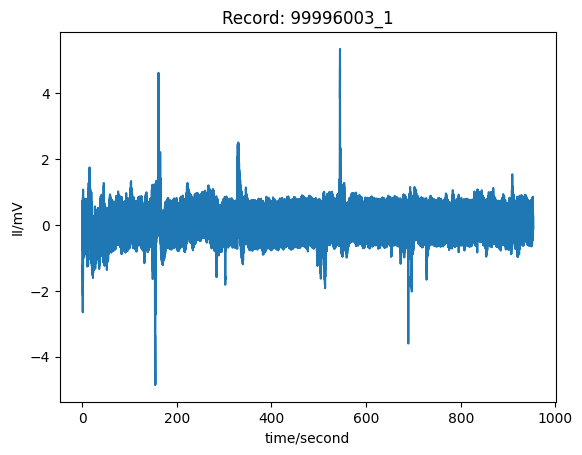

In [29]:
wfdb.plot_wfdb(record=record1)

In [30]:
record2 = records[1]
print(record2.__dict__)

{'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.13973566],
       [-0.12085246],
       [-0.0868627 ],
       ...,
       [ 0.33989754],
       [ 0.22659836],
       [ 0.17372541]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_2.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [264.78567552902877], 'baseline': [393], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [356], 'checksum': [27762], 'block_size': [0]}


In [79]:
get_start_end_times(record2)

Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


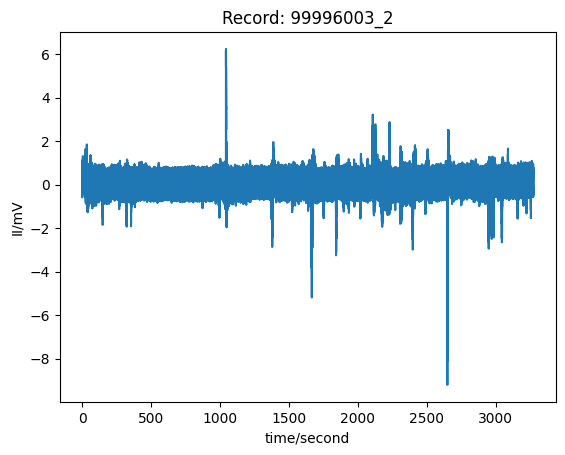

In [32]:
wfdb.plot_wfdb(record=record2)

In [73]:
alarms_df[alarms_df['CSN'] == Full_CSN]

,CSN,Alarm
440,99996003,2225-03-31 12:08:57


In [101]:
alarms_df['CSN'].shape

(425,)

In [100]:
alarms_df['CSN'].unique().shape

(425,)

In [76]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm']

440   2225-03-31 12:08:57
Name: Alarm, dtype: datetime64[us]

In [86]:
for record in records:
    get_start_end_times(record)
    print("\n")

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


Date: 2225-03-31
Start time: 13:36:23.572000
End time: 16:44:12.792000




### cut off time up to 1 min before the alarm/ cardiac arrest

In [109]:
record = records[0]

record.__dict__

{'record_name': '99996003_1',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 476497,
 'base_time': datetime.time(12, 0, 13, 772000),
 'base_date': datetime.date(2225, 3, 31),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[-0.024923  ],
        [-0.0199384 ],
        [-0.0099692 ],
        ...,
        [ 0.0348922 ],
        [ 0.23427618],
        [ 0.33396817]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99996003_1.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [401.23583934088566],
 'baseline': [-99],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-109],
 'checksum': [17044],
 'block_size': [0]}

In [152]:
alarm_ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
measurements = get_measurements(record1, alarm_ts, cutoff_minutes = 1)
print(measurements[:5])
print("Sanity check for last entry: ", measurements[-1])

['12:00:13.772000, -0.024923', '12:00:13.774000, -0.019938', '12:00:13.776000, -0.009969', '12:00:13.778000, -0.009969', '12:00:13.780000, -0.019938']
Sanity check for last entry:  12:07:57, -0.044861


In [ ]:
# Each entry consists of a timestamp and the corresponding measurement value at that timestamp.


In [292]:
def get_measurements(record, alarm_ts=None, cutoff_minutes=1, new_fs=50):
    """
    new_fs: the downsampled number of samples taken per second (i.e. Hz)
    """
    signal = record.p_signal[:, 0]  # 1D array of measurements 
    start_time = datetime.combine(record.base_date, record.base_time)

    formatted = []

    # Determine cutoff time in seconds since start
    if alarm_ts is None:
        end_time = start_time + timedelta(seconds=record.sig_len / record.fs)
        cutoff_time = end_time - timedelta(minutes=cutoff_minutes)
    else:
        cutoff_time = alarm_ts - timedelta(minutes=cutoff_minutes)
    total_duration = (cutoff_time - start_time).total_seconds()
    max_idx = min(len(signal), int(total_duration * record.fs))

    step_sz = int(record.fs // new_fs)

    for i in range(0, max_idx, step_sz):
        current_time = start_time + timedelta(seconds=i / record.fs)
        # formatted.append(f"{current_time.time()}, {signal[i]:.6f}")
        formatted.append(signal[i])
    return np.array(formatted), start_time, cutoff_time, new_fs
